## Fine-Tuning the ViT Model (on the NIH and CheXpert Datasets)

### Part 1: Importing Libraries, Setting Directories, and Writing a Configuration Dictionary

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from transformers import ViTModel
import numpy as np
import random
import os
import cv2
import matplotlib.pyplot as plt
from tqdm import tqdm
import zipfile
import pandas as pd
from PIL import Image

In [2]:
# Setting Google Drive location
from google.colab import drive
drive.mount('/content/drive')
project_directory_drive = "/content/drive/MyDrive/"

# Setting random seed
seed = 42
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
torch.backends.cudnn.benchmark = True

# Choosing device (GPU if available)
device = "cuda" if torch.cuda.is_available() else "cpu"
print("Device:", device)
print("Saving to:", project_directory_drive)


Mounted at /content/drive
Device: cuda
Saving to: /content/drive/MyDrive/


In [3]:
# -----------------------------------------------------------------------------------
# CENTRAL CONFIG DICTIONARY (so I can see and edit all hyperparameters in one place)
# -----------------------------------------------------------------------------------
config = {

    "dataset": "chexpert",

    # ---------------- Training hyperparameters ----------------
    "num_epochs": 10,
    "batch_size": 16,
    "learning_rate": 2e-5,
    "weight_decay": 1e-4,

    # ---------------- Scheduler hyperparameters ----------------
    "scheduler_Tmax": 10,

    # ---------------- Model architecture settings ----------------
    "num_classes": 2,
    "vit_name": "google/vit-base-patch16-224",
    "hidden_dim": 128,
    "img_size": 224,

    # ---------------- Pretrained ViT MoCo checkpoint ----------------
    "pretrained_vit_checkpoint": "/content/drive/MyDrive/Project_Eval/Models/vit_moco_checkpoint_epoch_10.pth",

    # CHEXPERT BINARY DATA
    # ======================================================================

    # ---------------- ZIP paths for extraction (CheXpert) ----------------
    "chexpert_zip_train": "/content/drive/MyDrive/Project_Eval/Datasets/CheXpert/Binary/binary_train.zip",
    "chexpert_zip_val":   "/content/drive/MyDrive/Project_Eval/Datasets/CheXpert/Binary/binary_val.zip",
    "chexpert_zip_test":  "/content/drive/MyDrive/Project_Eval/Datasets/CheXpert/Binary/binary_test.zip",

    # ---------------- Extraction directories (CheXpert) ----------------
    "chexpert_extract_train": "/tmp/CheXpert_binary_train/",
    "chexpert_extract_val":   "/tmp/CheXpert_binary_val/",
    "chexpert_extract_test":  "/tmp/CheXpert_binary_test/",

    # ---------------- CSVs for image labels (CheXpert) ----------------
    "chexpert_csv_train": "/content/drive/MyDrive/Project_Eval/Datasets/CheXpert/Binary/0_final_project_updated_names_train_transfer_binary.csv",
    "chexpert_csv_val":   "/content/drive/MyDrive/Project_Eval/Datasets/CheXpert/Binary/0_final_project_updated_names_val_transfer_binary.csv",
    "chexpert_csv_test":  "/content/drive/MyDrive/Project_Eval/Datasets/CheXpert/Binary/0_final_project_updated_names_test_transfer_binary.csv",

    # ======================================================================

    # NIH DATA
    # ======================================================================

    # ---------------- ZIP paths for extraction (NIH) ----------------
    "nih_zip_train": "/content/drive/MyDrive/Project_Eval/Datasets/NIH/train.zip",
    "nih_zip_val":   "/content/drive/MyDrive/Project_Eval/Datasets/NIH/val.zip",
    "nih_zip_test":  "/content/drive/MyDrive/Project_Eval/Datasets/NIH/test.zip",

    # ---------------- Extraction directories (NIH) ----------------
    "nih_extract_train": "/tmp/NIH_train/",
    "nih_extract_val":   "/tmp/NIH_val/",
    "nih_extract_test":  "/tmp/NIH_test/",

    # ---------------- CSV paths (NIH) ----------------
    "nih_csv_train": "/content/drive/MyDrive/Project_Eval/Datasets/NIH/nih_train.csv",
    "nih_csv_val":   "/content/drive/MyDrive/Project_Eval/Datasets/NIH/nih_val.csv",
    "nih_csv_test":  "/content/drive/MyDrive/Project_Eval/Datasets/NIH/nih_test.csv",

    # ======================================================================

    # ---------------- CHECKPOINT SAVING ----------------
    "save_every_epoch": True,
    "save_best_model": True,
    "output_checkpoint_dir": "/content/drive/MyDrive/Project_Eval/Models/"
}


In [4]:
# ------------------------------- !!!!!!!!!!!!
# UNZIPPING CHEXPERT BINARY TRAIN DATA (I am unzipping the training images into a temporary working directory)
# ------------------------------- !!!!!!!!!!!!
zip_path = config["chexpert_zip_train"]
extract_dir = config["chexpert_extract_train"]
os.makedirs(extract_dir, exist_ok=True)

with zipfile.ZipFile(zip_path, 'r') as z:
    for f in tqdm(z.namelist(), desc="Unzipping CheXpert Binary Train"):
        z.extract(f, extract_dir)

CHEXPERT_BINARY_TRAIN_IMAGES = os.path.join(config["chexpert_extract_train"], "train")
CHEXPERT_BINARY_TRAIN_CSV = config["chexpert_csv_train"]

# ------------------------------- !!!!!!!!!!!!
# UNZIPPING CHEXPERT BINARY VAL DATA (I am unzipping the validation images into a temporary working directory)
# ------------------------------- !!!!!!!!!!!!
zip_path = config["chexpert_zip_val"]
extract_dir = config["chexpert_extract_val"]
os.makedirs(extract_dir, exist_ok=True)

with zipfile.ZipFile(zip_path, 'r') as z:
    for f in tqdm(z.namelist(), desc="Unzipping CheXpert Binary Val"):
        z.extract(f, extract_dir)

CHEXPERT_BINARY_VAL_IMAGES   = os.path.join(config["chexpert_extract_val"], "val")
CHEXPERT_BINARY_VAL_CSV = config["chexpert_csv_val"]

# ===================================================================
# ------------------------- NIH DATA --------------------------------
# ===================================================================

# ------------------------------- !!!!!!!!!!!!
# UNZIPPING NIH TRAIN DATA (I am unzipping the NIH training images into a temporary working directory)
# ------------------------------- !!!!!!!!!!!!
zip_path = config["nih_zip_train"]
extract_dir = config["nih_extract_train"]
os.makedirs(extract_dir, exist_ok=True)

with zipfile.ZipFile(zip_path, 'r') as z:
    for f in tqdm(z.namelist(), desc="Unzipping NIH Train"):
        z.extract(f, extract_dir)

NIH_TRAIN_IMAGES = os.path.join(extract_dir, "train/")
NIH_TRAIN_CSV = config["nih_csv_train"]


# ------------------------------- !!!!!!!!!!!!
# UNZIPPING NIH VAL DATA (I am unzipping the NIH validation images into a temporary working directory)
# ------------------------------- !!!!!!!!!!!!
zip_path = config["nih_zip_val"]
extract_dir = config["nih_extract_val"]
os.makedirs(extract_dir, exist_ok=True)

with zipfile.ZipFile(zip_path, 'r') as z:
    for f in tqdm(z.namelist(), desc="Unzipping NIH Val"):
        z.extract(f, extract_dir)

NIH_VAL_IMAGES = os.path.join(extract_dir, "val/")
NIH_VAL_CSV = config["nih_csv_val"]

Unzipping NIH Val: 100%|██████████| 63/63 [00:01<00:00, 39.24it/s]


In [5]:
class NIH_Dataset(torch.utils.data.Dataset):
    def __init__(self, csv_path, img_root, transform=None):
        self.df = pd.read_csv(csv_path)
        self.img_root = img_root
        self.transform = transform

        # Label column
        if "Pneumonia" in self.df.columns:
            self.label_col = "Pneumonia"
        else:
            raise ValueError("CSV must contain 'Pneumonia' column.")

        # Path column
        if "Path" in self.df.columns:
            self.path_col = "Path"
        elif "path" in self.df.columns:
            self.path_col = "path"
        else:
            raise ValueError("CSV must contain 'Path' or 'path' column.")

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]

        img_rel_path = row[self.path_col]
        img_path = os.path.join(self.img_root, img_rel_path)

        if not os.path.exists(img_path):
            raise FileNotFoundError(
                f"Missing image:\n"
                f"  CSV: {img_rel_path}\n"
                f"  Tried: {img_path}"
            )

        image = Image.open(img_path).convert("RGB")
        label = int(row[self.label_col])

        if self.transform:
            image = self.transform(image)

        return image, label


### Part 2: Defining Patch Scoring Head

In [6]:
class PatchScoringHead(nn.Module):
    def __init__(self, embed_dim, hidden_dim=128):
        super().__init__()

        # Simple 2-layer MLP to score each patch embedding
        self.fc1 = nn.Linear(embed_dim, hidden_dim)
        self.relu = nn.ReLU(inplace=True)
        self.fc2 = nn.Linear(hidden_dim, 1)

    def forward(self, x):
        # Passing patch embeddings through scoring network
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        return x.squeeze(-1)

In [7]:
class PatchScoringViT(nn.Module):
  def __init__(self, num_classes=2, hidden_dim=128):
      super().__init__()

      # Loading a pretrained ViT (as used for the MoCo training step).
      # I am using the official ViT base patch16 architecture.
      self.vit = ViTModel.from_pretrained("google/vit-base-patch16-224")
      embed_dim = self.vit.config.hidden_size

      # Creating the patch scoring network.
      self.scorer = PatchScoringHead(embed_dim, hidden_dim)

      # Creating the classification head that takes in the pooled embedding.
      self.classifier = nn.Linear(embed_dim, num_classes)

  def forward(self, images):
      # Running the images through the ViT to get the CLS embedding and patch embeddings.
      vit_output = self.vit(images)

      # Removing the CLS token because we want only the patch-level information for scoring.
      patch_embeddings = vit_output.last_hidden_state[:, 1:, :]

      # Scoring all patch embeddings.
      patch_scores = self.scorer(patch_embeddings)

      # Softmaxing the patch scores to normalize them into valid weights.
      patch_weights = torch.softmax(patch_scores, dim=1)

      # Performing weighted patch pooling to create a single embedding for the entire image.
      pooled_embedding = torch.sum(patch_weights.unsqueeze(-1) * patch_embeddings, dim=1)

      # Passing the pooled embedding into the final classification head.
      logits = self.classifier(pooled_embedding)

      return logits, patch_scores

### Part 3: Defining Dataloaders

In [8]:
def build_dataloaders():
    # I am resizing images to match the ViT input resolution.
    transform = transforms.Compose([
        transforms.Resize((config["img_size"], config["img_size"])),
        transforms.ToTensor()
    ])

    # Switching between CheXpert and NIH depending on config selection
    if config["dataset"].lower() == "chexpert":
        # Using ImageFolder because CheXpert binary ZIPs already contain train/ and val/ subfolders
        train_dataset = NIH_Dataset(CHEXPERT_BINARY_TRAIN_CSV, CHEXPERT_BINARY_TRAIN_IMAGES, transform)
        val_dataset   = NIH_Dataset(CHEXPERT_BINARY_VAL_CSV,   CHEXPERT_BINARY_VAL_IMAGES,   transform)

    elif config["dataset"].lower() == "nih":
        # Using NIH CSV-based dataset loader
        train_dataset = NIH_Dataset(NIH_TRAIN_CSV, NIH_TRAIN_IMAGES, transform)
        val_dataset   = NIH_Dataset(NIH_VAL_CSV,   NIH_VAL_IMAGES,   transform)

    else:
        raise ValueError("Unknown dataset. Choose 'chexpert' or 'nih' in config['dataset'].")

    # Creating dataloaders for training and validation datasets
    train_loader = DataLoader(train_dataset, batch_size=config["batch_size"], shuffle=True)
    val_loader   = DataLoader(val_dataset,   batch_size=config["batch_size"], shuffle=False)

    return train_loader, val_loader

## Part 4: Writing Validation and Training Functions

In [ ]:
def evaluate_epoch_on_validation_set(model, dataloader, loss_function):
    # Putting the model in eval mode and instantiating prediction and loss counts.
    model.eval()
    running_loss_epoch = 0.0
    correct_predictions_epoch = 0
    total_predictions_epoch = 0

    # We do not need gradients for evaluation (so I am stopping gradient tracking to conserve memory).
    with torch.no_grad():
        for images, labels in dataloader:
            images = images.to(device)
            labels = labels.to(device)

            # Running the forward pass through the model.
            outputs, _ = model(images)

            # Computing loss.
            loss = loss_function(outputs, labels)
            running_loss_epoch += loss.item() * labels.size(0)

            # Getting the predicted labels (using the class with maximum logit value).
            _, predicted_class_labels = torch.max(outputs, 1)

            # Counting correct predictions.
            min_length = min(predicted_class_labels.size(0), labels.size(0))
            for i in range(min_length):
                total_predictions_epoch += 1
                if predicted_class_labels[i].item() == labels[i].item():
                    correct_predictions_epoch += 1

    # Computing average loss and classification accuracy.
    average_loss_epoch = running_loss_epoch / (total_predictions_epoch + 1e-8)
    percent_correct_epoch = (correct_predictions_epoch / total_predictions_epoch) * 100

    return average_loss_epoch, percent_correct_epoch


In [ ]:
def train_patchscoring_vit():
    # Building the training and validation dataloaders.
    train_loader, val_loader = build_dataloaders()

    # Creating the Patch-Scoring ViT model.
    vit_model = PatchScoringViT(
        num_classes=config["num_classes"],
        hidden_dim=config["hidden_dim"]
    ).to(device)

    # Loading MoCo checkpoint (if exists).
    print("Loading MoCo pretrained checkpoint:", config["pretrained_vit_checkpoint"])
    vit_model.load_state_dict(
        torch.load(config["pretrained_vit_checkpoint"], map_location=device),
        strict=False
    )


    # DEFINING OPTIMIZER, SCHEDULER, AND LOSS FUNCTION
    epochs=config["num_epochs"]
    learning_rate=config["learning_rate"]
    weight_decay=config["weight_decay"]

    optimizer = optim.AdamW(vit_model.parameters(), lr=learning_rate, weight_decay=weight_decay)
    scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=epochs)
    loss_function = nn.CrossEntropyLoss()

    # Creating lists for logging training/validation metrics.
    training_losses = []
    validation_losses = []
    validation_accuracies = []

    best_validation_loss = float("inf")
    best_model_file = os.path.join(project_directory_drive, "best_patchscore_vit.pth")

    print("Starting training...\n")

    for epoch in tqdm(range(0, epochs), desc="Training", unit="epoch"):
        # Putting model in training mode and instantiating prediction and loss counts.
        vit_model.train()
        running_loss = 0.0
        total_predictions = 0

        for images, labels in train_loader:
            images = images.to(device)
            labels = labels.to(device)

            # Resetting the parameter gradients (so the prior epoch gradients are not comingled with the current ones).
            optimizer.zero_grad()

            # Performing the forward pass (with mixed precision).
            outputs, _ = vit_model(images)
            loss = loss_function(outputs, labels)

            # Performing the backward and optimization steps.
            loss.backward()
            optimizer.step()

            # Accumulating the running loss and total predictions (for printing).
            running_loss += loss.item() * labels.size(0)
            total_predictions += labels.size(0)

        # Computing average training loss for this epoch.
        training_loss = running_loss / total_predictions

        # Evaluating on the validation set after this training epoch.
        validation_loss, validation_accuracy = evaluate_epoch_on_validation_set(
            vit_model, val_loader, loss_function
        )

        # Logging metrics.
        training_losses.append(training_loss)
        validation_losses.append(validation_loss)
        validation_accuracies.append(validation_accuracy)

        # Saving best model checkpoint.
        if validation_loss < best_validation_loss:
            best_validation_loss = validation_loss
            torch.save(vit_model.state_dict(), best_model_file)

        # Printing training and validation results (matching your exact format).
        print(
            f"[Epoch {epoch + 1}/{epochs}] "
            f"Train Loss: {training_loss:.4f}, "
            f"Val Loss: {validation_loss:.4f}, "
            f"Val Acc: {validation_accuracy:.2f}%"
        )

        # Stepping the learning rate scheduler.
        scheduler.step()

    print("Training completed. Best model saved to:", best_model_file)

    return vit_model, training_losses, validation_losses, validation_accuracies

In [ ]:
trained_model, training_losses, validation_losses, validation_accuracies = train_patchscoring_vit()

Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Loading MoCo pretrained checkpoint: /content/drive/MyDrive/Project_Eval/Models/vit_moco_checkpoint_epoch_10.pth
Starting training...



Training:  10%|█         | 1/10 [01:27<13:04, 87.21s/epoch]

[Epoch 1/10] Train Loss: 0.6510, Val Loss: 0.6180, Val Acc: 66.06%


Training:  20%|██        | 2/10 [02:53<11:34, 86.83s/epoch]

[Epoch 2/10] Train Loss: 0.5914, Val Loss: 0.6246, Val Acc: 63.98%


Training:  30%|███       | 3/10 [04:20<10:06, 86.58s/epoch]

[Epoch 3/10] Train Loss: 0.4830, Val Loss: 0.6357, Val Acc: 66.79%


Training:  40%|████      | 4/10 [05:46<08:38, 86.49s/epoch]

[Epoch 4/10] Train Loss: 0.2799, Val Loss: 0.8945, Val Acc: 65.25%


Training:  50%|█████     | 5/10 [07:12<07:12, 86.47s/epoch]

[Epoch 5/10] Train Loss: 0.0780, Val Loss: 1.2107, Val Acc: 64.34%


Training:  60%|██████    | 6/10 [08:38<05:45, 86.34s/epoch]

[Epoch 6/10] Train Loss: 0.0147, Val Loss: 1.5671, Val Acc: 62.99%


Training:  70%|███████   | 7/10 [10:05<04:18, 86.32s/epoch]

[Epoch 7/10] Train Loss: 0.0026, Val Loss: 1.7461, Val Acc: 63.08%


Training:  80%|████████  | 8/10 [11:31<02:52, 86.29s/epoch]

[Epoch 8/10] Train Loss: 0.0013, Val Loss: 1.8153, Val Acc: 62.99%


Training:  90%|█████████ | 9/10 [12:57<01:26, 86.27s/epoch]

[Epoch 9/10] Train Loss: 0.0010, Val Loss: 1.8484, Val Acc: 62.90%


Training: 100%|██████████| 10/10 [14:24<00:00, 86.43s/epoch]

[Epoch 10/10] Train Loss: 0.0009, Val Loss: 1.8581, Val Acc: 63.26%
Training completed. Best model saved to: /content/drive/MyDrive/best_patchscore_vit.pth


## Part 6: Patch-Level Visualization

In [10]:
# 1) Recreate the exact same model class
model = PatchScoringViT(num_classes=2).to(device)

# 2) Load weights
state_dict = torch.load("/content/drive/MyDrive/best_patchscore_vit.pth", map_location=device)
model.load_state_dict(state_dict)

model.eval()
print("✓ Loaded best_patchscore_vit.pth successfully.")

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json: 0.00B [00:00, ?B/s]

model.safetensors:   0%|          | 0.00/346M [00:00<?, ?B/s]

Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


✓ Loaded best_patchscore_vit.pth successfully.


In [11]:
def visualize_patch_importance(model, dataloader, device, k=10):
    import numpy as np
    import matplotlib.pyplot as plt
    import cv2
    import torch

    # 1) Get one sample from loader
    model.eval()
    images, labels = next(iter(dataloader))
    img = images[0].to(device)              # (3,224,224)

    with torch.no_grad():
        logits, patch_scores = model(img.unsqueeze(0))

    patch_scores = patch_scores[0]          # (196,)

    # 2) Prep score data
    scores = patch_scores.detach().cpu().numpy()
    topk_idx = np.argsort(scores)[-k:]      # top-K patch indices

    # Convert indices → patch grid coords
    coords = [(i // 14, i % 14) for i in topk_idx]

    # 3) Convert image for drawing
    img_np = img.cpu().permute(1,2,0).numpy()
    img_np = (img_np * 255).astype(np.uint8)
    img_draw = img_np.copy()

    patch_size = 16   # for ViT-B/16

    # 4) Draw red bounding boxes
    for (r, c) in coords:
        y1, x1 = r * patch_size, c * patch_size
        y2, x2 = y1 + patch_size, x1 + patch_size
        cv2.rectangle(img_draw, (x1, y1), (x2, y2), (255,0,0), 2)

    # 5) Display result
    plt.figure(figsize=(6,6))
    plt.imshow(img_draw)
    plt.axis("off")
    plt.title(f"Top {k} Highest-Scoring Patches (Red Boxes)")
    plt.show()

    return img_draw, scores


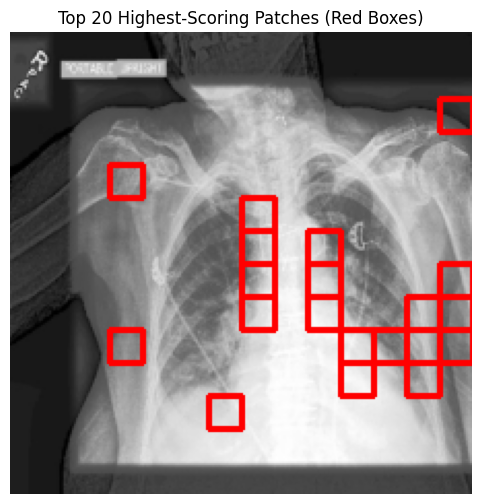

In [ ]:
_ = visualize_patch_importance(trained_model, val_loader, device, k=20)

In [66]:
def visualize_patch_scores(image_tensor, scores):
    # Converting image from tensor to numpy for OpenCV
    img = image_tensor.permute(1, 2, 0).cpu().numpy()
    img = (img * 255).astype(np.uint8)

    # Normalizing patch scores (so color map has meaningful scale)
    s = scores.detach().cpu().numpy()
    s = (s - s.min()) / (s.max() - s.min() + 1e-8)

    # Reshaping to ViT patch grid (14x14 for ViT-B/16)
    s = s.reshape(14, 14)

    # Upscaling patch heatmap to full image resolution
    s = cv2.resize(s, (224, 224))

    # Generating heatmap overlay
    heatmap = cv2.applyColorMap((s * 255).astype(np.uint8), cv2.COLORMAP_JET)
    heatmap = cv2.cvtColor(heatmap, cv2.COLOR_BGR2RGB)

    # Combining heatmap with original image (weighted blend)
    overlay = (0.5 * img + 0.5 * heatmap).astype(np.uint8)

    # Displaying both images side-by-side
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.imshow(img)
    plt.axis("off")
    plt.title("Original Image")

    plt.subplot(1, 2, 2)
    plt.imshow(overlay)
    plt.axis("off")
    plt.title("Patch Score Heatmap (Rainbow)")


    plt.show()


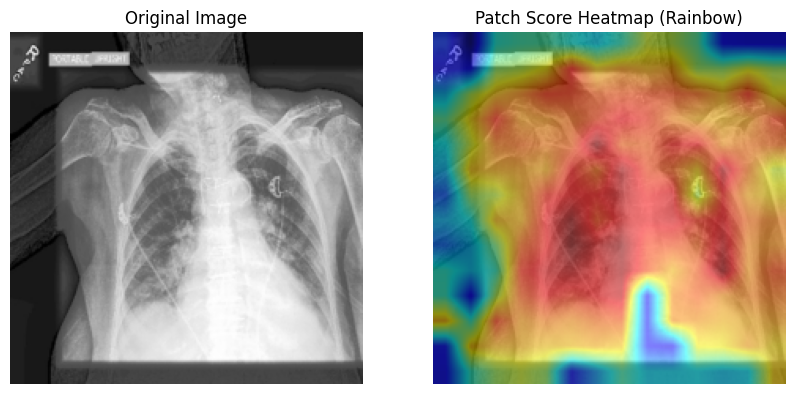

In [67]:
# === VISUALIZE PATCH SCORES ON ONE VALIDATION SAMPLE ===

# 1. Rebuild validation loader exactly like in training
_, val_loader = build_dataloaders()

# 2. Get one batch
images, labels = next(iter(val_loader))

# 3. Pick first image
img = images[0].to(device)

# 4. Run model forward pass to get logits + patch_scores
model.eval()
with torch.no_grad():
    logits, patch_scores = model(img.unsqueeze(0))

# 5. IMPORTANT: remove batch dimension and move to CPU
patch_scores = patch_scores[0]    # shape: (196,)
img_vis = img.cpu()               # already in [0,1] because you did NOT normalize

# 6. Visualize patch importance heatmap
visualize_patch_scores(img_vis, patch_scores)




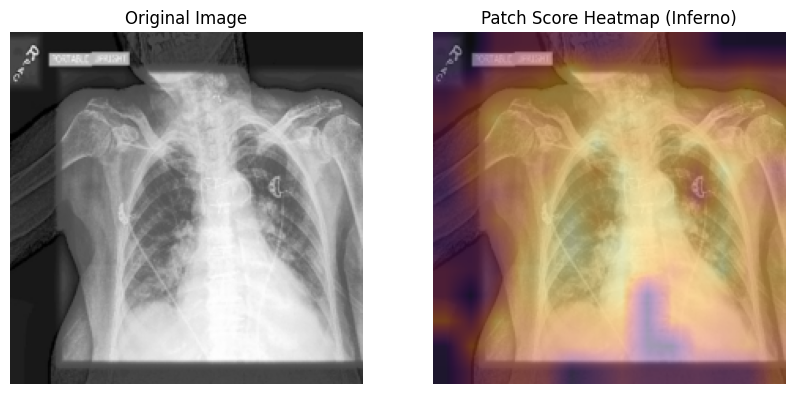

In [80]:
import matplotlib.cm as cm

def visualize_patch_scores_clinical(image_tensor, scores):
    import numpy as np
    import matplotlib.pyplot as plt
    import cv2
    import torch

    # Convert image to uint8
    img = image_tensor.permute(1,2,0).cpu().numpy()
    img = (img * 255).astype(np.uint8)

    # Normalize scores
    s = scores.detach().cpu().numpy()
    s = (s - s.min()) / (s.max() - s.min() + 1e-8)

    # 14x14 → 224x224 smooth upsample
    heat = s.reshape(14, 14)
    heat = cv2.resize(heat, (224, 224), interpolation=cv2.INTER_LINEAR)

    # Use perceptual colormap (inferno = clinically preferred)
    cmap = cm.inferno
    heat_color = (cmap(heat)[..., :3] * 255).astype(np.uint8)

    # Blend with image
    overlay = (0.6 * img + 0.4 * heat_color).astype(np.uint8)

    # Display
    fig, ax = plt.subplots(1,2, figsize=(10,5))
    ax[0].imshow(img)
    ax[0].axis("off")
    ax[0].set_title("Original Image")

    ax[1].imshow(overlay)
    ax[1].axis("off")
    ax[1].set_title("Patch Score Heatmap (Inferno)")


    plt.show()
visualize_patch_scores_clinical(img_vis, patch_scores)


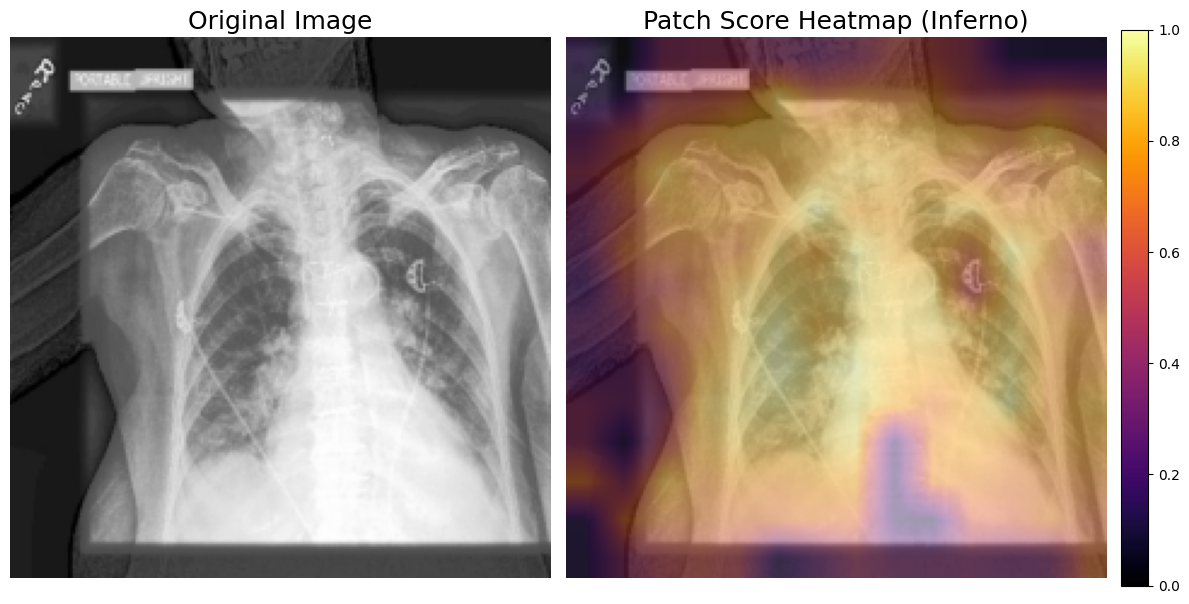

In [86]:
def visualize_patch_scores_clinical(image_tensor, scores):
    import numpy as np
    import matplotlib.pyplot as plt
    import cv2
    import matplotlib.cm as cm
    from matplotlib import gridspec

    # --- Convert image to displayable uint8 ---
    img = image_tensor.permute(1,2,0).cpu().numpy()
    img = (img * 255).astype(np.uint8)

    # --- Normalize patch scores but keep true min/max for colorbar ---
    s = scores.detach().cpu().numpy()
    s_min, s_max = s.min(), s.max()
    s_norm = (s - s_min) / (s_max - s_min + 1e-8)

    # --- 14x14 → 224x224 heatmap ---
    heat = s_norm.reshape(14, 14)
    heat = cv2.resize(heat, (224, 224), interpolation=cv2.INTER_LINEAR)

    # --- Colorize ---
    cmap = cm.inferno
    heat_color = (cmap(heat)[..., :3] * 255).astype(np.uint8)

    # --- Blend with original ---
    overlay = (0.6 * img + 0.4 * heat_color).astype(np.uint8)

    # --- Grid layout to prevent squeezing ---
    fig = plt.figure(figsize=(12,6))
    gs = gridspec.GridSpec(1, 3, width_ratios=[1, 1, 0.05])

    ax0 = plt.subplot(gs[0])
    ax1 = plt.subplot(gs[1])
    cax = plt.subplot(gs[2])  # dedicated colorbar axis

    # Left: Original
    ax0.imshow(img)
    ax0.axis("off")
    ax0.set_title("Original Image", fontsize=18)

    # Right: Heatmap overlay
    im = ax1.imshow(overlay)
    ax1.axis("off")
    ax1.set_title("Patch Score Heatmap (Inferno)", fontsize=18)

    # Colorbar with true raw score scale
    norm = plt.Normalize(vmin=0.0, vmax=1.0)
    sm = cm.ScalarMappable(norm=norm, cmap="inferno")
    sm.set_array([])

    cb = plt.colorbar(sm, cax=cax)

    plt.tight_layout()
    plt.show()


visualize_patch_scores_clinical(img_vis, patch_scores)


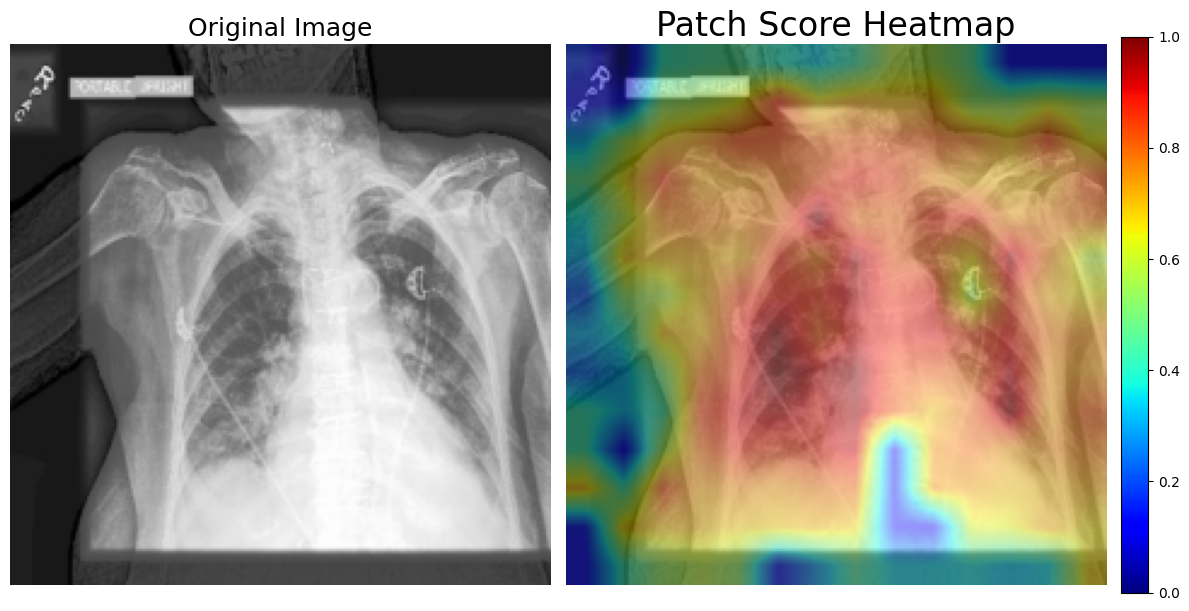

In [92]:
def visualize_patch_scores_clinical(image_tensor, scores):
    import numpy as np
    import matplotlib.pyplot as plt
    import cv2
    import matplotlib.cm as cm
    from matplotlib import gridspec

    # --- Convert image to displayable uint8 ---
    img = image_tensor.permute(1,2,0).cpu().numpy()
    img = (img * 255).astype(np.uint8)

    # --- Normalize patch scores but keep true min/max for colorbar ---
    s = scores.detach().cpu().numpy()
    s_min, s_max = s.min(), s.max()
    s_norm = (s - s_min) / (s_max - s_min + 1e-8)

    # --- 14x14 → 224x224 heatmap ---
    heat = s_norm.reshape(14, 14)
    heat = cv2.resize(heat, (224, 224), interpolation=cv2.INTER_LINEAR)

    # --- Colorize ---
    cmap = cm.jet
    heat_color = (cmap(heat)[..., :3] * 255).astype(np.uint8)

    # --- Blend with original ---
    overlay = (0.6 * img + 0.4 * heat_color).astype(np.uint8)

    # --- Grid layout to prevent squeezing ---
    fig = plt.figure(figsize=(12,6))
    gs = gridspec.GridSpec(1, 3, width_ratios=[1, 1, 0.05])

    ax0 = plt.subplot(gs[0])
    ax1 = plt.subplot(gs[1])
    cax = plt.subplot(gs[2])  # dedicated colorbar axis

    # Left: Original
    ax0.imshow(img)
    ax0.axis("off")
    ax0.set_title("Original Image", fontsize=18)

    # Right: Heatmap overlay
    im = ax1.imshow(overlay)
    ax1.axis("off")
    ax1.set_title("Patch Score Heatmap", fontsize=24)


    # Colorbar with true raw score scale
    norm = plt.Normalize(vmin=0.0, vmax=1.0)
    sm = cm.ScalarMappable(norm=norm, cmap="jet")
    sm.set_array([])

    cb = plt.colorbar(sm, cax=cax)

    plt.tight_layout()
    plt.show()


visualize_patch_scores_clinical(img_vis, patch_scores)


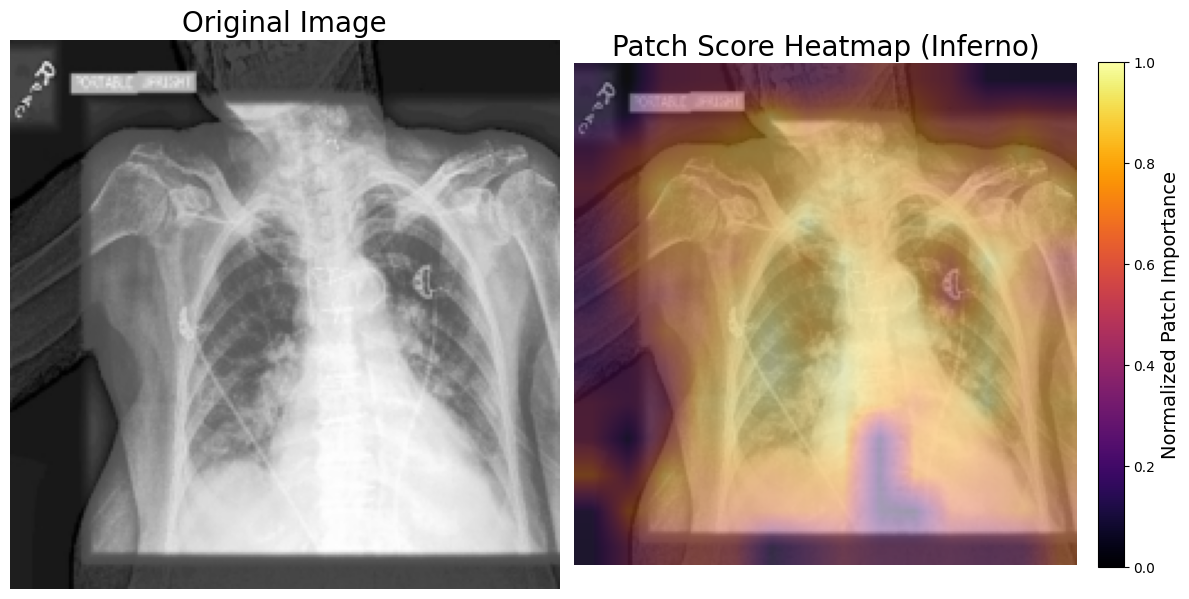

In [76]:
def visualize_patch_scores_clinical(image_tensor, scores):
    import numpy as np
    import matplotlib.pyplot as plt
    import cv2
    import matplotlib.cm as cm
    from matplotlib import gridspec

    # Convert image to displayable uint8 ---
    img = image_tensor.permute(1,2,0).cpu().numpy()
    img = (img * 255).astype(np.uint8)

    # Normalize patch scores
    s = scores.detach().cpu().numpy()
    s_norm = (s - s.min()) / (s.max() - s.min() + 1e-8)

    # 14x14 → 224x224 heatmap
    heat = s_norm.reshape(14, 14)
    heat = cv2.resize(heat, (224, 224), interpolation=cv2.INTER_LINEAR)

    # Colorize
    cmap = cm.inferno
    heat_color = (cmap(heat)[..., :3] * 255).astype(np.uint8)

    # Blend with original
    overlay = (0.6 * img + 0.4 * heat_color).astype(np.uint8)

    # Grid layout with 2 main axes only
    fig = plt.figure(figsize=(12,6))
    gs = gridspec.GridSpec(1, 2, width_ratios=[1, 1])

    ax0 = plt.subplot(gs[0])
    ax1 = plt.subplot(gs[1])

    # Original
    ax0.imshow(img)
    ax0.axis("off")
    ax0.set_title("Original Image", fontsize=20)

    # Heatmap overlay
    im = ax1.imshow(overlay)
    ax1.axis("off")
    ax1.set_title("Patch Score Heatmap (Inferno)", fontsize=20)

    # Colorbar
    norm = plt.Normalize(vmin=0.0, vmax=1.0)
    sm = cm.ScalarMappable(norm=norm, cmap="inferno")
    sm.set_array([])

    # Colorbar same height as heatmap ---
    cb = fig.colorbar(sm, ax=ax1, fraction=0.046, pad=0.04)
    cb.set_label("Normalized Patch Importance", fontsize=14)

    plt.tight_layout()
    plt.show()


visualize_patch_scores_clinical(img_vis, patch_scores)


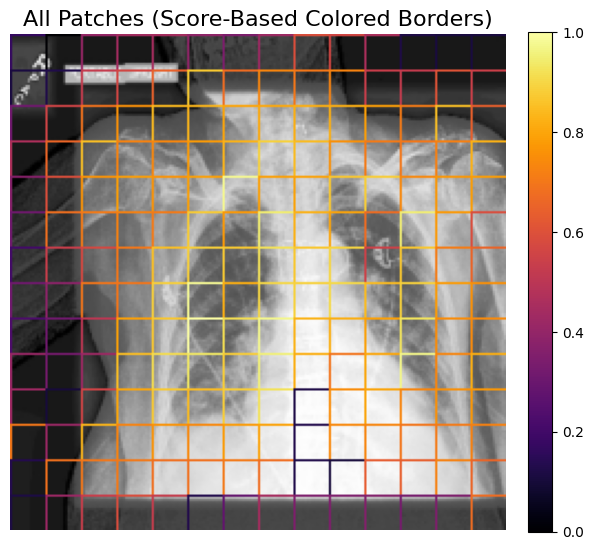

array([[[53,  9, 96],
        [53,  9, 96],
        [53,  9, 96],
        ...,
        [26, 11, 64],
        [26, 11, 64],
        [26, 11, 64]],

       [[53,  9, 96],
        [39, 39, 39],
        [39, 39, 39],
        ...,
        [22, 22, 22],
        [16, 16, 16],
        [22, 22, 22]],

       [[53,  9, 96],
        [46, 46, 46],
        [45, 45, 45],
        ...,
        [25, 25, 25],
        [24, 24, 24],
        [24, 24, 24]],

       ...,

       [[29, 12, 69],
        [30, 30, 30],
        [30, 30, 30],
        ...,
        [67, 67, 67],
        [50, 50, 50],
        [39, 39, 39]],

       [[29, 12, 69],
        [30, 30, 30],
        [30, 30, 30],
        ...,
        [65, 65, 65],
        [56, 56, 56],
        [38, 38, 38]],

       [[29, 12, 69],
        [30, 30, 30],
        [30, 30, 30],
        ...,
        [68, 68, 68],
        [60, 60, 60],
        [40, 40, 40]]], dtype=uint8)
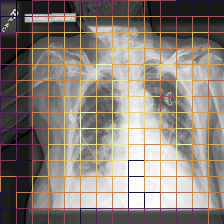

In [89]:
def visualize_all_patches(image_tensor, patch_scores):
    import numpy as np
    import matplotlib.pyplot as plt
    import cv2
    import matplotlib.cm as cm

    img = image_tensor.permute(1,2,0).cpu().numpy()
    img = (img * 255).astype(np.uint8)

    # Normalize patch scores
    s = patch_scores.detach().cpu().numpy()
    s_norm = (s - s.min()) / (s.max() - s.min() + 1e-8)
    grid = s_norm.reshape(14,14)

    cmap = cm.inferno
    patch_size = 16
    img_draw = img.copy()

    # DRAW BORDERS
    for r in range(14):
        for c in range(14):
            score = grid[r,c]

            rgb = np.array(cmap(score)[:3]) * 255
            rgb = rgb.astype(np.uint8)
            color = (int(rgb[0]), int(rgb[1]), int(rgb[2]))

            y1, x1 = r * patch_size, c * patch_size
            y2, x2 = y1 + patch_size, x1 + patch_size

            cv2.rectangle(img_draw, (x1, y1), (x2, y2), color, 1)

    # PLOT WITH COLORBAR
    fig, ax = plt.subplots(figsize=(7,7))

    im = ax.imshow(img_draw)
    ax.axis("off")
    ax.set_title("All Patches (Score-Based Colored Borders)", fontsize=16)

    # Create colorbar using normalized scale (0–1)
    norm = plt.Normalize(vmin=0.0, vmax=1.0)
    sm = cm.ScalarMappable(norm=norm, cmap=cmap)
    sm.set_array([])

    # add colorbar matching height of the image
    cbar = fig.colorbar(sm, ax=ax, fraction=0.046, pad=0.04)

    plt.show()

    return img_draw

visualize_all_patches(img_vis, patch_scores)